In [2]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [14]:
import database
db = database.db
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0

In [15]:
# # data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
# data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0
# print(data_dir_full)
# # load data
# mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# # sessionPulses=mat_to_return['sessionPulses']
# # filtered = mat_to_return['filtered']
# behavior=mat_to_return['behavior']
# # ripples = mat_to_return['ripples']
# cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
cell_cols_d = prep_res['cell_cols_d']
# beh_df = prep_res['beh_df']
# beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
# spike_trains = prep_res['spike_trains']


In [16]:
sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')

import fr_map_one_session as fmos
fr_map_res = fmos.main(data_dir_full,force_reload=False,load_only=True)
fr_map_trial_df = fr_map_res['fr_map_trial_df']

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/fr_map_with_int.p exists; loading---


In [17]:
import sys
sys.path.append('/mnt/home/szheng/projects/wishart-process')
import visualizations
import models
import inference
import jax.numpy as jnp
import jax
from numpyro import optim
import evaluation
import numpyro

In [28]:
ti=0
tt=0
fr_map_trial_df_onett=fr_map_trial_df.loc[0,0]

In [48]:
# fr_map_trial_df_onett = fr_map_trial_df.loc[0].unstack(level=0).swaplevel(0,1,axis=1).sort_index(axis=1)

In [18]:
# fr_map_trial_df_onett = fr_map_trial_df.loc[ti,0:32]

In [45]:
import numpy as np
# treating trial as condition
data = fr_map_trial_df_onett#.swaplevel(0,1).sort_index(axis=0)
rol_win = 5
data=data.groupby(level=0).apply(lambda x:x.rolling(rol_win).mean()[rol_win::rol_win]).droplevel(0).dropna(axis=1,how='all')

ntrials = data.shape[1]
n_neurons = data.index.get_level_values(0).nunique()
y = data.values.reshape(n_neurons,-1,ntrials)
y = y.transpose(1,2,0) # trial (pos) x condition (trial) x neuron
y = (y - y.mean(axis=(0,1))[None,None,:]) / (y.std(axis=(0,1))[None,None,:]  +1e-10)
x = jnp.arange(y.shape[1],dtype=float)
# n_pos =y.shape[1]

In [10]:
data=fr_map_trial_df_onett.swaplevel(0,1).sort_index(axis=0)

# data = fr_map_trial_df_onett.dropna(axis=1,how='all')
rol_win = 5
# data=data.groupby(level=0).apply(lambda x:x.rolling(rol_win).mean()[rol_win::rol_win]).droplevel(0)
data=data.groupby(level=(0,1)).apply(lambda x:x.rolling(rol_win).mean()[rol_win::rol_win]).droplevel((0,1))

ntrials = data.shape[1]
n_neurons = data.index.get_level_values(0).nunique()
y = data.values.reshape(n_neurons,-1,ntrials)
y = y.transpose(2,1,0) # trial x condition (pos) x neuron
y = (y - y.mean(axis=(0,1))[None,None,:]) / (y.std(axis=(0,1))[None,None,:]  +1e-10)
x = jnp.arange(y.shape[1],dtype=float)
n_pos = y.shape[1]
x=jnp.array(np.stack(data.loc[1].index))

In [36]:
def kernel_tmaze(x,y,sigma_kernel=5.,central_arm_thresh=33.,diag_fac=1.):
    dist = jnp.exp(-jnp.linalg.norm(x[1]-y[1])**2/(2*sigma_kernel**2)) 
    k = (x[0]==y[0]) * dist + \
    (x[0]!=y[0]) *(x[1]<=central_arm_thresh) * (y[1]<=central_arm_thresh) * dist  + (x[0]==y[0])*(x[1]==y[1])*diag_fac
    return k
    
    

In [37]:
from jax import vmap

In [38]:
k_l = vmap(vmap(kernel_tmaze,in_axes=(0,None)),in_axes=(None,0))(x,x)


KeyboardInterrupt



In [19]:
np.linalg.eig(k_l)

(array([5.5905585 , 4.5332937 , 3.4615822 , 3.3665185 , 3.2184331 ,
        3.451017  , 2.9772    , 3.291209  , 2.684222  , 3.046862  ,
        2.7463903 , 2.3912168 , 2.1683388 , 2.42168   , 1.9712771 ,
        2.1027298 , 1.7383327 , 0.68356395, 1.8134285 , 1.5415338 ,
        1.4333006 , 1.5692104 , 1.3233144 , 1.3767276 , 1.2109598 ,
        1.1517168 , 1.2351574 , 1.1210179 , 1.1384995 , 1.072409  ,
        1.0782596 , 1.0447742 , 1.0460869 , 0.9991784 , 1.        ,
        1.        , 1.        , 1.        ], dtype=float32),
 array([[-1.75260425e-01, -3.06286305e-01, -1.29242137e-01, ...,
          7.07088172e-01, -3.27226110e-02, -4.74966727e-02],
        [-2.88370252e-01, -3.51328135e-01, -6.82659373e-02, ...,
          1.23469159e-03,  1.70106411e-01, -5.81890464e-01],
        [-3.54763985e-01, -1.71380028e-01,  7.53144100e-02, ...,
         -4.97100176e-03, -6.84855580e-01, -3.98504972e-01],
        ...,
        [-8.67822735e-07,  2.95897444e-05, -1.33849025e-01, ...,
       

In [49]:
import jax
from numpyro import optim

import models
import inference

# RBF kernel
sigma_kernel = 1.#0.1
kernel_rbf = lambda x, y: jnp.all(x==y)*1e-3+jnp.exp(-jnp.linalg.norm(x-y)**2/(2*sigma_kernel**2))
# kernel_rbf = lambda x, y: jnp.exp(-2*jnp.sin(jnp.pi*jnp.abs((x-y)/n_pos)/(sigma_kernel**2)))
kernel = kernel_rbf#kernel_tmaze

# Prior models
nu = 3
gp = models.GaussianProcess(kernel=kernel,num_dims=n_neurons) # N is the number of neurons
wp = models.WishartLRDProcess(kernel=kernel,nu=nu,V=jnp.eye(n_neurons))
likelihood = models.NormalConditionalLikelihood(n_neurons)

In [58]:
# Given
# -----
# x : ndarray, (num_conditions x num_variables), stimulus conditions.
# y : ndarray, (num_trials x num_conditions x num_neurons), neural firing rates across C conditions repeated for K trials.

# Infer a posterior over neural means and covariances per condition.

seed = 1

# Joint distribution
joint = models.JointGaussianWishartProcess(gp,wp,likelihood) 

# Mean field variational family
varfam = inference.VariationalNormal(joint.model)

# Running inference
varfam.infer(
    optim=optim.Adam(1e-1),
    x=x,y=y,
    n_iter=2000,
    key=jax.random.PRNGKey(seed)
)
joint.update_params(varfam.posterior)

/mnt/home/szheng/projects/wishart-process/inference.py:29: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  svi_result = svi.run(key, n_iter, x, y, stable_update=True)
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/home/szheng/ceph/envs/jaxgpu/lib/python3.9/site-packages/jax/_src/linear_util.py:188: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))
100%|██████████| 2000/2000 [00:20<00:00, 98.93it/s, init loss: 20644702.0000, avg. loss [1901-2000]: 437004.5938] 


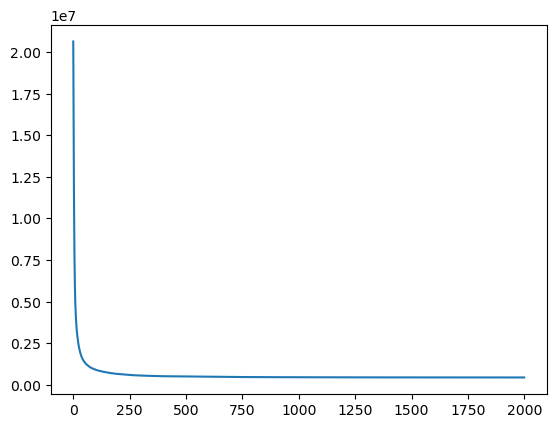

In [59]:
import matplotlib.pyplot as plt
plt.plot(varfam.losses)

In [148]:
joint

In [60]:
# Posterior distribution
posterior = models.NormalGaussianWishartPosterior(joint,varfam,x)

In [61]:
# Sample from the posterior
with numpyro.handlers.seed(rng_seed=seed):
    mu_hat, sigma_hat, F_hat = posterior.sample(x)

In [62]:
# Evaluate posterior mode
with numpyro.handlers.seed(rng_seed=seed):
    mu_hat, sigma_hat, F_hat = posterior.mode(x)

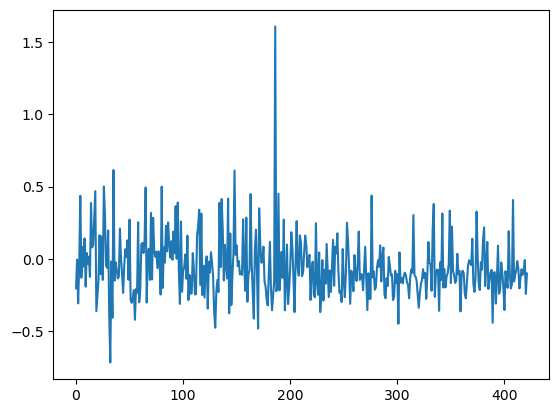

In [63]:
pos_ind=12
plt.plot(mu_hat[pos_ind])

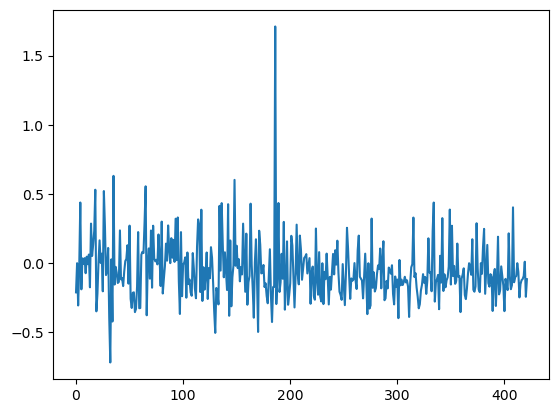

In [64]:

plt.plot(y[:,pos_ind,:].mean(axis=0))

In [66]:
import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

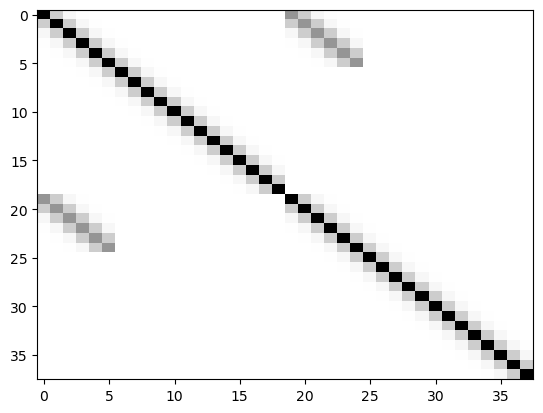

In [27]:
plt.imshow(k_l,aspect='auto')

/tmp/ipykernel_2813263/881139079.py:50: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.arange(npos))


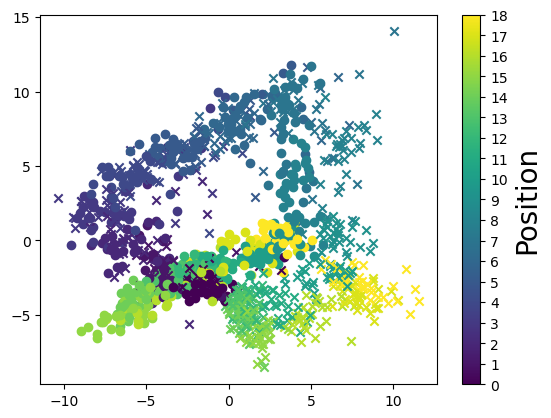

In [28]:
import numpy as np

# Assuming y is of shape (ntrial, ncondition, nneurons)
ntrial = y.shape[0]
ncondition = y.shape[1]
# _,ncondition = np.unique(x[:,0],return_counts=True)
# ncondition = len(ncondition)
_,npos = np.unique(x[:,1],return_counts=True)
npos=len(npos)
nneurons = y.shape[-1]
y_reshaped = y.reshape((ntrial * ncondition, nneurons))

from sklearn.decomposition import PCA

means = mu_hat

pca = PCA(n_components=2)
# pca.fit_transform(np.vstack(means))
pca.fit_transform(means)
y_pca = pca.transform(y_reshaped)

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define markers for trial types
markers = ['o', 'x']  # Example: 'o' for circle, 's' for square. Add more if needed.

# Create a colormap for positions
# cmap = plt.cm.Spectral
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=npos-1)

fig, ax = plt.subplots()


for i in range(ntrial):
    for j in range(ncondition):
        trial_type = j // npos
        position = j % npos
        
        # Get marker for trial type
        marker = markers[trial_type]
        
        # Get color for position
        color = cmap(norm(position))
        
        ax.scatter(y_pca[i*ncondition + j, 0], y_pca[i*ncondition + j, 1], marker=marker, color=color)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.arange(npos))
cbar.set_label('Position')
# Display the plot
plt.show()



In [68]:
import matplotlib.colors as mcolors
color_coord =x#x[:,1]
pos_l = np.unique(color_coord)
cmap = plt.cm.Spectral
norm = mcolors.Normalize(vmin=pos_l.min(), vmax=pos_l.max())
c_l=cmap(norm(color_coord))

/mnt/home/szheng/projects/wishart-process/visualizations.py:84: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


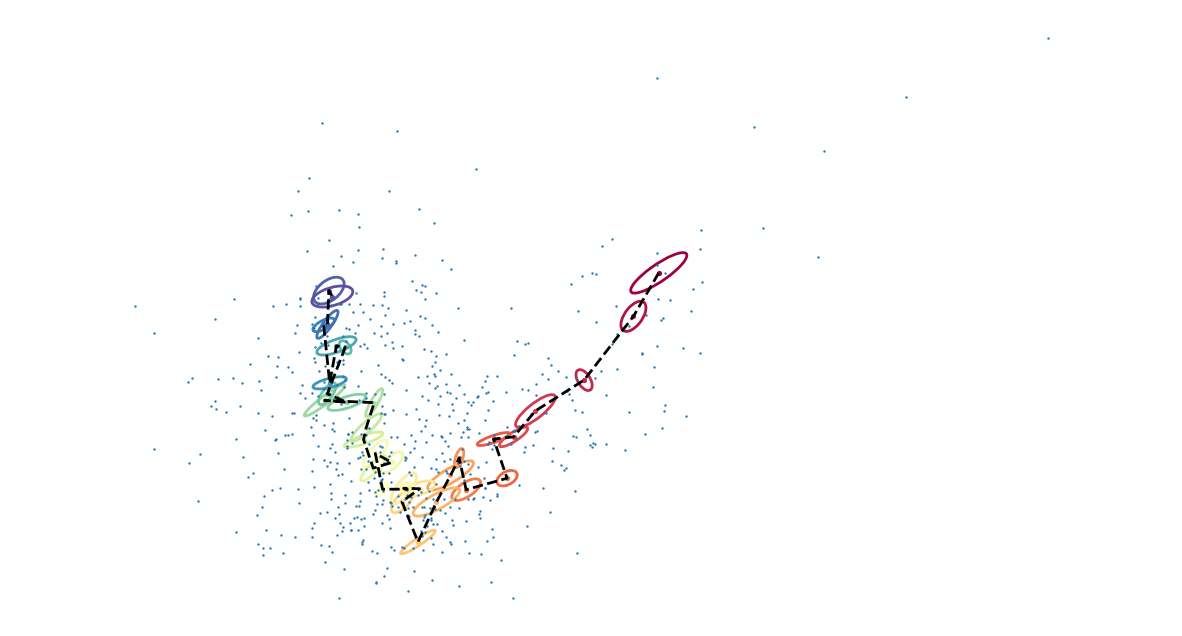

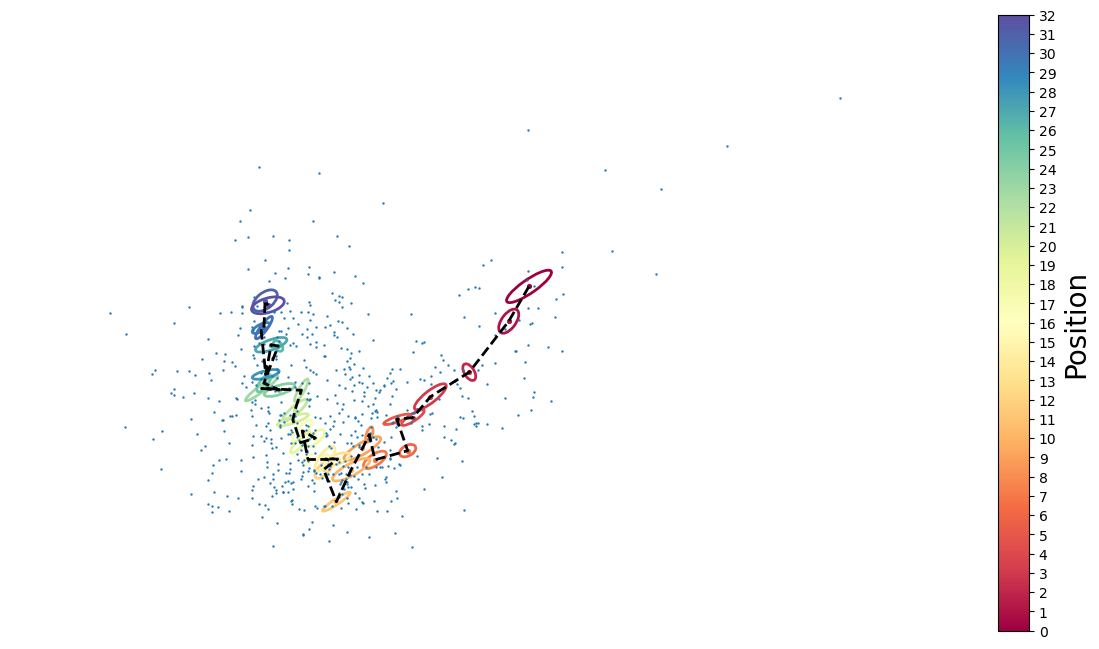

In [70]:
from visualizations import visualize_pc
import visualizations
reload(visualizations)
trialtype_ind = None#x[:,0]
fig,ax=visualizations.visualize_pc(mu_hat[:,None],sigma_hat,pc=y.reshape(-1,y.shape[-1]),std=.2,colors=c_l,
#                                    trialtype_ind=trialtype_ind
                                  )

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar =fig.colorbar(sm, ticks=pos_l,ax=ax)
cbar.set_label('Position')
fig
# Display the plot
# plt.show()


# visualize_pc(mu_hat[:,None],sigma_hat,pc=None)

In [142]:
from sklearn.covariance import LedoitWolf

In [144]:
y.shape

(19, 33, 422)

In [145]:
cov_lw_l=[]
for c in range(y.shape[1]):
    cov=LedoitWolf().fit(y[:,c,:])
    cov_one=cov.covariance_
    cov_lw_l.append(cov_one)
cov_lw_l = np.stack(cov_lw_l,axis=0)

/mnt/home/szheng/projects/wishart-process/visualizations.py:84: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


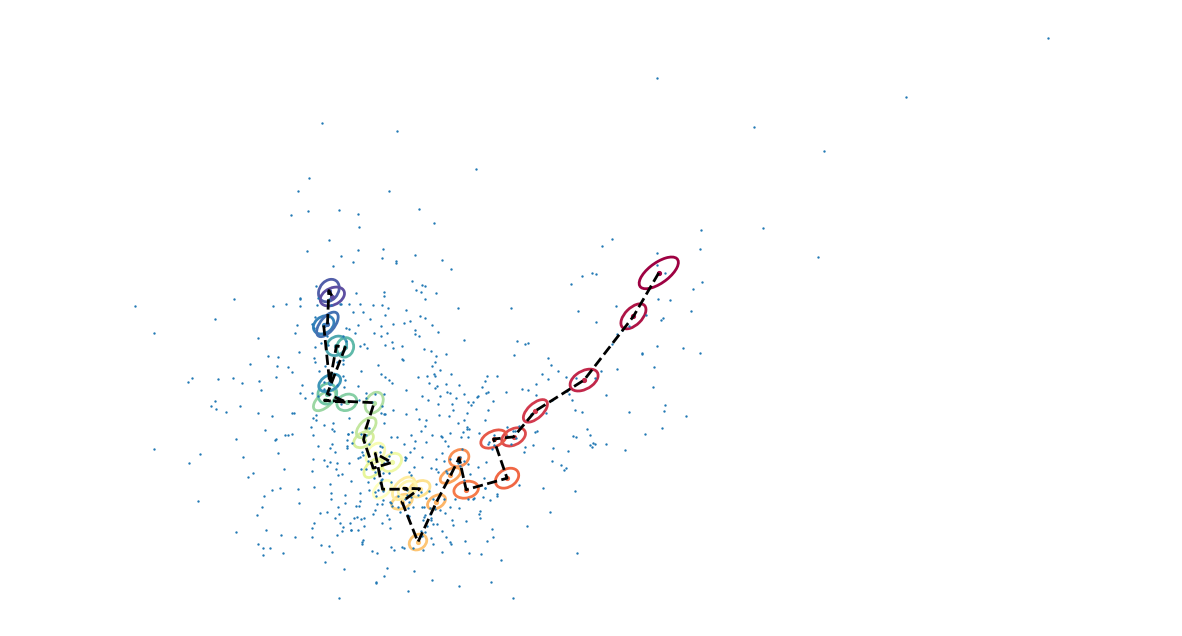

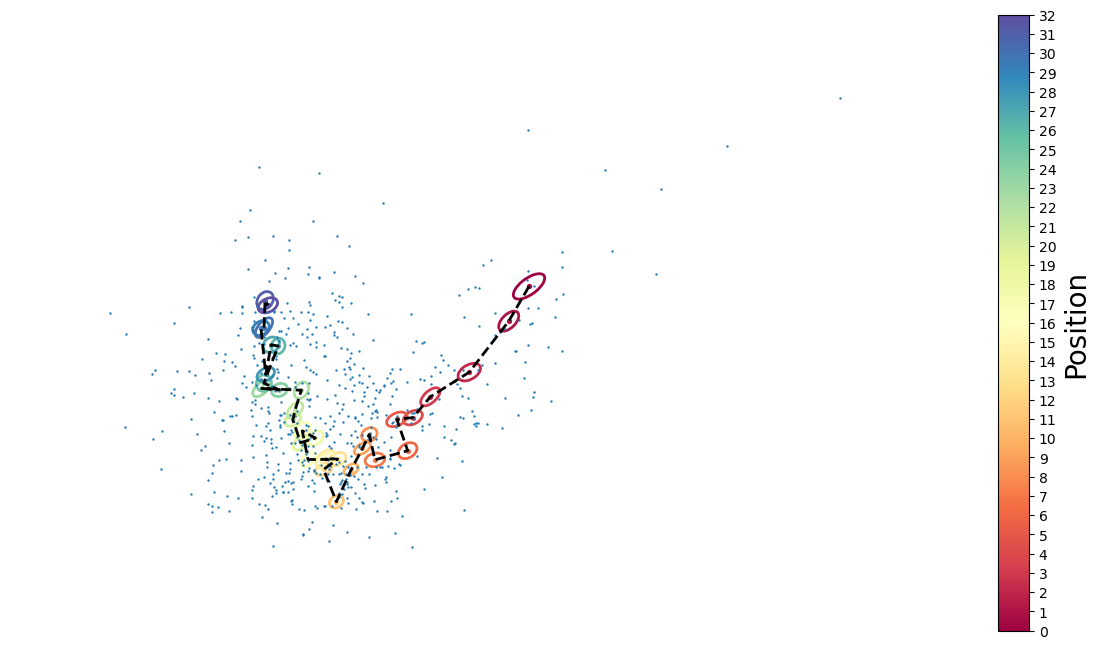

In [149]:
from visualizations import visualize_pc
import visualizations
reload(visualizations)
trialtype_ind = None#x[:,0]
fig,ax=visualizations.visualize_pc(mu_hat[:,None],cov_lw_l,pc=y.reshape(-1,y.shape[-1]),std=.2,colors=c_l,
#                                    trialtype_ind=trialtype_ind
                                  )

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar =fig.colorbar(sm, ticks=pos_l,ax=ax)
cbar.set_label('Position')
fig
# Display the plot
# plt.show()


# visualize_pc(mu_hat[:,None],sigma_hat,pc=None)

In [71]:
neuron_sorted_ind=y.mean(axis=0).argmax(axis=0).argsort()

NameError: name 'x_index' is not defined

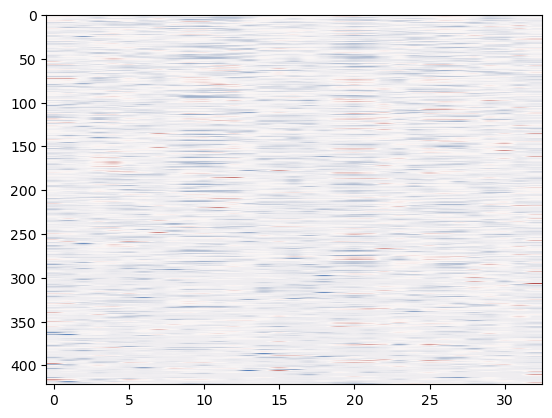

In [72]:
# fac_1 = F_hat[neuron_sorted_ind,0,:]
fac_1 = F_hat[:,0,:]
fig,ax=plt.subplots()
im=ax.imshow(fac_1,aspect='auto',cmap='vlag')
ax.set_xticks(np.arange(len(x_index))[::2])
ax.set_xticklabels(x_index[::2],rotation=45)
plt.colorbar(im)

In [340]:
pca = PCA(n_components=2)
mean_pc=pca.fit_transform(means)
fac_1 = F_hat[:,0,:]
fac_1_pc = pca.transform(fac_1.T)

/tmp/ipykernel_2813263/690854138.py:26: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=pos_l)


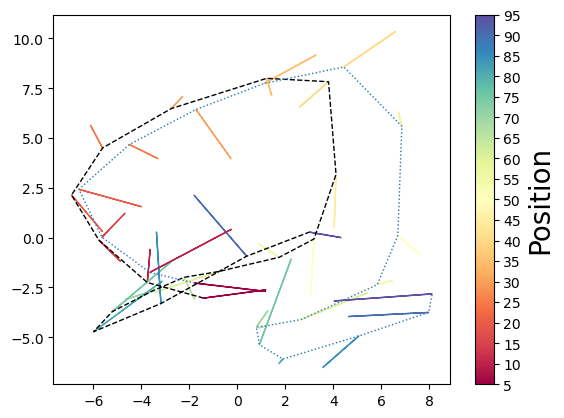

In [360]:
pos_l = np.unique(x[:,1])
cmap = plt.cm.Spectral
norm = mcolors.Normalize(vmin=pos_l.min(), vmax=pos_l.max())
c_l=cmap(norm(x[:,1]))

linestyle_l = ['k--',':','-']
linewidth=1
noptions=len(linestyle_l)
fig,ax=plt.subplots()
for i in np.unique(trialtype_ind):
    lst = linestyle_l[int(i%noptions)]
    # pdb.set_trace()
    means_plot = mean_pc
    means_sub = means_plot[trialtype_ind==i]
    ax.plot(
        means_sub[:,0],means_sub[:,1],lst,
        linewidth=linewidth
    )
for i in range(mean_pc.shape[0]):
    xx,yy=mean_pc[i]
    dx,dy = fac_1_pc[i]
    ax.arrow(xx,yy,dx,dy,color=c_l[i])
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=pos_l)
cbar.set_label('Position')


In [78]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

In [79]:

pca = PCA(n_components=10)
means = mu_hat
mean_pc=pca.fit_transform(means)
fac_1 = F_hat[:,0,:]
fac_1_pc = pca.transform(fac_1.T)
pca.explained_variance_ratio_

array([0.15431501, 0.09687094, 0.05780336, 0.04783032, 0.04549892,
       0.04238565, 0.03701413, 0.03514135, 0.03298856, 0.03100046],
      dtype=float32)

In [80]:
axis_corr_per_cond= squareform(pdist(fac_1.T,metric='cos'))
axis_corr_per_cond[axis_corr_per_cond>1] = axis_corr_per_cond[axis_corr_per_cond>1]-1
axis_corr_per_cond=pd.DataFrame(axis_corr_per_cond,index=x_index,columns=x_index)

axis_pc_corr_per_cond= squareform(pdist(fac_1_pc,metric='cos'))
axis_pc_corr_per_cond[axis_pc_corr_per_cond>1] = axis_pc_corr_per_cond[axis_pc_corr_per_cond>1]-1
axis_pc_corr_per_cond=pd.DataFrame(axis_pc_corr_per_cond,index=x_index,columns=x_index)

NameError: name 'x_index' is not defined

In [77]:
plt.plot(pos_l,np.diag(axis_corr_per_cond.loc[0][1]),marker='o')
plt.plot(pos_l,np.diag(axis_pc_corr_per_cond.loc[0][1]))

NameError: name 'axis_corr_per_cond' is not defined

In [493]:
fac_1_norm = fac_1/np.linalg.norm(fac_1,axis=1)[:,None]

y_proj_fac1=np.einsum('tcn,nc->tc',y,fac_1_norm)

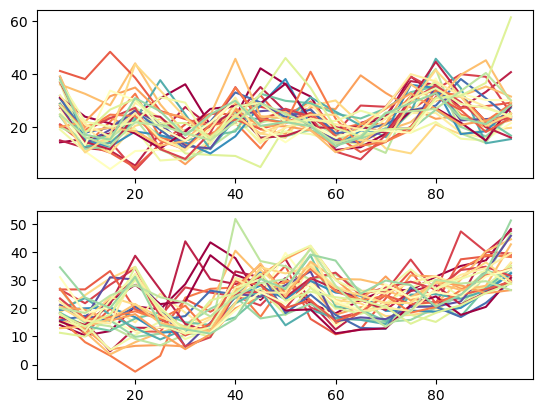

In [494]:
fig,axs=plt.subplots(2,1)
for tt in [0,1]:
    ax=axs[tt]
    tr_l=np.nonzero(trialtype_ind==tt)[0]
    for tr in range(y_proj_fac1.shape[0]):
        ax.plot(pos_l,y_proj_fac1[tr,trialtype_ind==tt],c=c_l[tr])


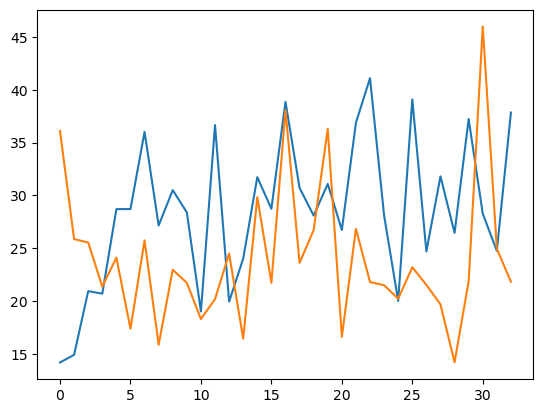

In [495]:
plt.plot(y_proj_fac1[:,0])
plt.plot(y_proj_fac1[:,9])

In [341]:
fac_1_pc

array([[ 2.59192   ,  0.4139681 ],
       [ 0.120013  ,  1.6694326 ],
       [ 0.89630735, -1.059957  ],
       [ 1.2868493 , -1.8285336 ],
       [-0.49896348,  1.134267  ],
       [ 0.47270596,  0.6055078 ],
       [ 0.2148588 , -0.86715657],
       [-1.210117  , -1.2734048 ],
       [-0.07713701, -2.666672  ],
       [-0.14491653, -2.836803  ],
       [-0.88347244,  0.68773913],
       [-2.7155976 , -1.0606952 ],
       [ 0.4421711 , -1.1080296 ],
       [-1.1481214 , -0.44857603],
       [ 2.4423754 ,  2.493692  ],
       [ 2.854107  ,  2.5356724 ],
       [-0.1858347 ,  3.5941794 ],
       [-2.190165  ,  3.0564957 ],
       [ 1.3147879 , -0.27405465],
       [ 2.9482646 , -0.41716892],
       [ 3.3951852 ,  2.1612425 ],
       [ 0.9604632 ,  1.2024229 ],
       [ 2.5979385 , -0.8669928 ],
       [ 1.1851473 , -0.707541  ],
       [ 1.4611386 , -2.4660592 ],
       [ 2.1728473 ,  1.4319621 ],
       [ 2.1586301 ,  1.7773854 ],
       [-0.14210485,  0.6972518 ],
       [ 0.9231779 ,

In [ ]:
fac_1

In [297]:
spk_beh_df.groupby(['trial_type','trial','lin_binned'])['speed_gauss'].mean()

trial_type  trial  lin_binned
(0, 0.0)    1.0    0             18.077324
                   1             11.151515
                   2              3.791443
                   3              2.991849
                   4              9.217257
                                   ...    
(0, 1.0)    69.0   95             9.846018
                   96            11.215518
                   97             2.605331
                   98             7.763383
                   99             4.837545
Name: speed_gauss, Length: 6853, dtype: float64

In [58]:
jnp.tile(x,(nsamples,1,1)).shape

(10, 38, 2)

In [53]:
x

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.17279335e-02, 3.16640549e-02, 3.14726763e-02, ...,
        3.14726763e-02, 3.16640549e-02, 3.17279335e-02],
       [6.34239197e-02, 6.32962268e-02, 6.29136624e-02, ...,
        6.29136624e-02, 6.32962268e-02, 6.34239197e-02],
       ...,
       [6.34239197e-02, 6.32962268e-02, 6.29136624e-02, ...,
        6.29136624e-02, 6.32962268e-02, 6.34239197e-02],
       [3.17279335e-02, 3.16640549e-02, 3.14726763e-02, ...,
        3.14726763e-02, 3.16640549e-02, 3.17279335e-02],
       [1.22464680e-16, 1.22218119e-16, 1.21479429e-16, ...,
        1.21479429e-16, 1.22218119e-16, 1.22464680e-16]])

In [82]:
# Sample from the posterior
nsamples=100
mu_hat_l = []
sigma_hat_l = []
with numpyro.handlers.seed(rng_seed=seed):
#     mu_hat_l, sigma_hat_l, F_hat_l = vmap(posterior.sample,in_axes=0)(jnp.tile(x,(nsamples,1,1)))
    for i in range(nsamples):
        mu_hat_, sigma_hat_, F_hat_ = posterior.sample(x)
        mu_hat_l.append(mu_hat_)
        sigma_hat_l.append(sigma_hat_)
mu_hat_l = jnp.stack(mu_hat_l,axis=0)
sigma_hat_l = jnp.stack(sigma_hat_l,axis=0)

In [255]:
sigma_hat_l.shape

(100, 38, 422, 422)

In [84]:
from jax import jit
@jit
def cov_to_corr(mat):
    D = jnp.diag(jnp.diag(mat) **(-1/2))
    corr=D.dot(mat).dot(D)
    return corr

In [87]:
corr_hat_l=[]
for sigma_s in sigma_hat_l:
    corr_s=vmap(cov_to_corr,in_axes=(0))(sigma_s)
    corr_hat_l.append(corr_s)
corr_hat_l=jnp.stack(corr_hat_l,axis=0)

In [88]:
import jax.scipy.linalg as jlinalg

In [89]:

# @jit
# def gauss_wass_d(m1,m2,s1,s2):
#     s1_sqrt = jlinalg.sqrtm(s1)
#     s2_sqrt = jlinalg.sqrtm(s2)
#     s_term = s1_sqrt.dot(s2_sqrt).dot(s1_sqrt)
#     s_term_sqrt = jlinalg.sqrtm(s_term)
#     d=jnp.linalg.norm(m1 - m2) ** 2 + jnp.trace(s1 + s2 - 2 * (s_term_sqrt))
#     return d

def gauss_wass_d(m1,m2,s1,s2):
    s1_sqrt = np.real(scipy.linalg.sqrtm(s1))
    s2_sqrt = np.real(scipy.linalg.sqrtm(s2))
    s_term = s1_sqrt.dot(s2).dot(s1_sqrt)
#     s_term_sqrt = np.real_if_close(scipy.linalg.sqrtm(s_term),tol=1e-2)
    s_term_sqrt = np.real(scipy.linalg.sqrtm(s_term))
    pdb.set_trace()
    d=np.linalg.norm(m1 - m2) ** 2 + np.trace(s1 + s2 - 2 * (s_term_sqrt))
    return d

def mean_euc_dist(m1,m2):
    d = jnp.linalg.norm(m1-m2)
    return d
    

In [90]:
gauss_wass_d(mu_hat_l[0,0],mu_hat_l[0,0],sigma_hat_l[0,0],sigma_hat_l[0,0])

> /tmp/ipykernel_37387/1556782872.py(17)gauss_wass_d()
     15     s_term_sqrt = np.real(scipy.linalg.sqrtm(s_term))
     16     pdb.set_trace()
---> 17     d=np.linalg.norm(m1 - m2) ** 2 + np.trace(s1 + s2 - 2 * (s_term_sqrt))
     18     return d
     19 

ipdb> c


-0.0053245387971401215

In [91]:
wass_per_cond=lambda m1,s1:vmap(vmap(gauss_wass_d,in_axes=(0,None,0,None)),in_axes=(None,0,None,0))(m1,m1,s1,s1)
euc_per_cond=lambda m1:vmap(vmap(mean_euc_dist,in_axes=(0,None)),in_axes=(None,0))(m1,m1)

# wass_d = vmap(wass_per_cond,in_axes=(0,0))(mu_hat_l,sigma_hat_l)
mean_euc_d = vmap(euc_per_cond,in_axes=0)(mu_hat_l)

In [93]:
from scipy.spatial.distance import pdist,squareform
def get_sigma_euc_d(sigma_hat_l):
    nsamples=sigma_hat_l.shape[0]
    ncondition=sigma_hat_l.shape[1]
    sigma_hat_l_reshape=sigma_hat_l.reshape(nsamples,ncondition,-1)
    sigma_euc_d = []
    for i in range(sigma_hat_l_reshape.shape[0]):
        d=squareform(pdist(sigma_hat_l_reshape[i]))
        sigma_euc_d.append(d)
    sigma_euc_d =np.stack(sigma_euc_d,axis=0)
    return sigma_euc_d

In [94]:
%%time
corr_euc_d = get_sigma_euc_d(corr_hat_l)
sigma_euc_d = get_sigma_euc_d(sigma_hat_l)

CPU times: user 13 s, sys: 1.36 s, total: 14.3 s
Wall time: 14.5 s


In [95]:
mean_euc_d_mean=mean_euc_d.mean(axis=0)
sigma_euc_d_mean = sigma_euc_d.mean(axis=0)
corr_euc_d_mean = corr_euc_d.mean(axis=0)

mean_euc_d_std = mean_euc_d.std(axis=0)
sigma_euc_d_std = sigma_euc_d.std(axis=0)
corr_euc_d_std = corr_euc_d.std(axis=0)

In [99]:
if len(x.shape)>1:
    x_index = pd.MultiIndex.from_tuples([tuple(i) for i in np.array(x)])
    x_index
else:
    x_index=pd.Index(x)

In [100]:
mean_euc_d_mean = pd.DataFrame(mean_euc_d_mean,index=x_index.T,columns=x_index)
sigma_euc_d_mean = pd.DataFrame(sigma_euc_d_mean,index=x_index.T,columns=x_index)
corr_euc_d_mean = pd.DataFrame(corr_euc_d_mean,index=x_index.T,columns=x_index)

mean_euc_d_std = pd.DataFrame(mean_euc_d_std,index=x_index.T,columns=x_index)
sigma_euc_d_std = pd.DataFrame(sigma_euc_d_std,index=x_index.T,columns=x_index)
corr_euc_d_std = pd.DataFrame(corr_euc_d_std,index=x_index.T,columns=x_index)

In [101]:
euc_d_all = {'mean':(mean_euc_d_mean,mean_euc_d_std),
             'sigma':(sigma_euc_d_mean,sigma_euc_d_std),
             'corr':(corr_euc_d_mean,corr_euc_d_std),
            }

In [106]:
x_index.nlevels

1

In [107]:
def plot_next_and_across_tt(dist_mean_df,sem_df=None,sem_sc=1.96,fig=None,ax=None):
    if ax is None:
        fig,ax=plt.subplots()
    x_index= dist_mean_df.index
    lst_l = ['--',':']

    for tt in x_index.get_level_values(0):
        mat=dist_mean_df.loc[tt,tt]
        if sem_df is not None:
            mat_sem=sem_df.loc[tt,tt] * sem_sc
            ax.errorbar(mat.index[:-1],np.diag(mat,1),yerr=np.diag(mat_sem,1),marker='o',c='C0',ms=1.,linestyle=lst_l[int(tt)])
        else:
            ax.plot(mat.index[:-1],np.diag(mat,1),marker='o',c='C0',ms=1.,linestyle=lst_l[int(tt)])
    mat=dist_mean_df.loc[0][1]
    
    if sem_df is not None:
        mat_sem=sem_df.loc[0][1] * sem_sc
        ax.errorbar(mat.index,np.diag(mat),yerr=np.diag(mat_sem),marker='o',c='C1',ms=1.)
    else:
        ax.plot(mat.index,np.diag(mat),c='C1',marker='o',ms=1.)
    return fig,ax

    

In [132]:
def zscore_diff(m1_l,m2_l):
    m1 = m1_l.mean(axis=0)
    m2 = m2_l.mean(axis=0)
    s1 = m1_l.std(axis=0)
    s2 = m2_l.std(axis=0)
    d=jnp.linalg.norm((m1-m2) / jnp.sqrt((s1**2 + s2**2))) / np.sqrt(m1_l.shape[-1])
    return d
    

In [140]:
def get_sigma_zscore_d(sigma_hat_l):
    nsamples=sigma_hat_l.shape[0]
    ncondition=sigma_hat_l.shape[1]
    sigma_hat_l_reshape=sigma_hat_l.reshape(nsamples,ncondition,-1)
    sigma_euc_d = np.nonzero(ncondition,ncondition)
    for i in range(ncondition):
        for j in range(ncondition):
            sigma_euc_d[i,j]=zscore_diff(sigma_hat_l_reshape[:,i],sigma_hat_l_reshape[:,j])



    return sigma_euc_d

In [133]:
mu_z_dist=vmap(vmap(zscore_diff,in_axes=(1,None)),in_axes=(None,1))(mu_hat_l,mu_hat_l)

In [141]:
# corr_hat_l_reshape=corr_hat_l.reshape(corr_hat_l.shape[0],corr_hat_l.shape[1],-1)
corr_zscore_d=get_sigma_zscore_d(corr_hat_l)

2023-11-03 14:19:40.130758: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.19GiB (rounded to 2350708992)requested by op 
2023-11-03 14:19:40.130943: W external/tsl/tsl/framework/bfc_allocator.cc:497] **__*____________*_*___________********************_____***************************************_____
2023-11-03 14:19:40.130983: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2461] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2350708800 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    2.19GiB
              constant allocation:         0B
        maybe_live_out allocation:    2.19GiB
     preallocated temp allocation:         0B
                 total allocation:    4.38GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 2.19GiB
		Entry Parameter Subshape: f32[100,33,422,422]

	Buffer

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2350708800 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    2.19GiB
              constant allocation:         0B
        maybe_live_out allocation:    2.19GiB
     preallocated temp allocation:         0B
                 total allocation:    4.38GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 2.19GiB
		Entry Parameter Subshape: f32[100,33,422,422]
		==========================

	Buffer 2:
		Size: 2.19GiB
		XLA Label: copy
		Shape: f32[100,33,178084]
		==========================



<Axes: >

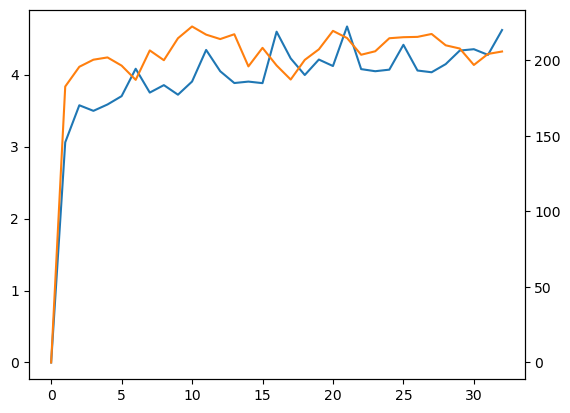

In [135]:
p=0
fig,ax=plt.subplots()
# mean_euc_d_mean.loc[p].plot(ax=ax)
ax.plot(mu_z_dist[p])
ax2=ax.twinx()
corr_euc_d_mean.loc[p].plot(ax=ax2,color='C1')

AttributeError: 'numpy.float32' object has no attribute 'index'

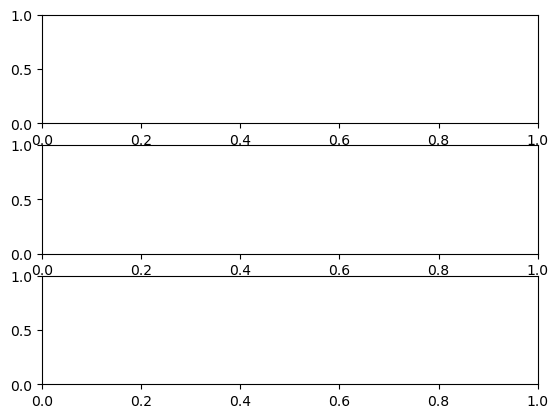

In [108]:
fig,axs=plt.subplots(3,1)
title_l = ['mean euc','cov euc','corr euc']
key_l = ['mean','sigma','corr']
for ii,(k,(dist_mean_df,dist_std_df)) in enumerate(euc_d_all.items()):
    ax=axs[ii]
    plot_next_and_across_tt(dist_mean_df,sem_df=dist_std_df,fig=fig,ax=ax)
    ax.set_title(title_l[ii])

plt.tight_layout()

In [235]:
np.diag(mean_euc_d_mean.loc[tt,tt])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)

In [233]:
mean_euc_d_mean.loc[tt,tt]

,5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0,90.0,95.0
5.0,0.000000,7.247109,12.615873,15.379159,15.737829,16.132292,17.037748,19.264099,19.610268,18.662357,20.053755,17.717516,17.012835,16.458691,16.650938,17.962616,17.955227,19.476784,21.056206
10.0,7.247109,0.000000,8.197021,12.615053,13.718551,14.454049,15.712111,18.405037,19.049995,17.794506,18.999617,16.456764,15.691945,15.142365,15.570296,17.091217,17.313137,19.041203,20.824064
15.0,12.615873,8.197021,0.000000,7.696313,11.291911,13.308486,15.141669,18.025694,19.225830,18.271475,19.218063,16.425993,15.688937,15.044309,15.433347,16.982077,17.415140,19.361477,21.101030
20.0,15.379159,12.615053,7.696313,0.000000,7.279802,11.988441,15.069456,18.355255,19.983492,19.401394,20.304508,17.545668,16.778601,16.090620,16.432796,17.767853,18.170792,20.020252,21.368788
25.0,15.737829,13.718551,11.291911,7.279802,0.000000,7.297320,12.046227,16.626299,19.072365,18.817966,19.892578,17.296282,16.414387,15.649290,16.157280,17.457777,17.507738,19.313370,20.674694
30.0,16.132292,14.454049,13.308486,11.988441,7.297320,0.000000,7.355537,14.053603,17.829105,18.156101,19.533712,17.146263,16.244532,15.582477,16.209377,17.571491,17.510099,19.200821,20.829992
35.0,17.037748,15.712111,15.141669,15.069456,12.046227,7.355537,0.000000,9.654019,15.613951,17.884663,19.763893,17.763615,16.948088,16.346794,16.900194,18.283216,18.221760,19.668159,21.360056
40.0,19.264099,18.405037,18.025694,18.355255,16.626299,14.053603,9.654019,0.000000,10.279712,18.349243,21.114693,19.827990,19.433882,18.907198,19.282635,20.453665,20.197828,21.186310,22.527676
45.0,19.610268,19.049995,19.225830,19.983492,19.072365,17.829105,15.613951,10.279712,0.000000,15.435696,20.555214,20.456442,20.376652,19.839615,20.184170,21.235029,20.856899,21.540049,22.548586
50.0,18.662357,17.794506,18.271475,19.401394,18.817966,18.156101,17.884663,18.349243,15.435696,0.000000,10.352530,16.715649,18.672403,18.508177,19.027971,20.328548,20.372257,21.405775,22.722486


In [207]:
# adjacent distance
for p in 
mean_euc_d_mean
# same location distance


Array([[ 0.      ,  8.716007, 15.257954, ..., 19.97123 , 20.9743  ,
        21.016842],
       [ 8.716007,  0.      ,  9.513909, ..., 18.349163, 19.954176,
        21.306509],
       [15.257954,  9.513909,  0.      , ..., 17.680002, 19.552948,
        21.14558 ],
       ...,
       [19.97123 , 18.349163, 17.680002, ...,  0.      , 10.416314,
        18.457382],
       [20.9743  , 19.954176, 19.552948, ..., 10.416314,  0.      ,
        12.610334],
       [21.016842, 21.306509, 21.14558 , ..., 18.457382, 12.610334,
         0.      ]], dtype=float32)

/tmp/ipykernel_2813263/3024422447.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(pos_l)


[Text(-5.0, 0, '5.0'),
 Text(0.0, 0, '10.0'),
 Text(5.0, 0, '15.0'),
 Text(10.0, 0, '20.0'),
 Text(15.0, 0, '25.0'),
 Text(20.0, 0, '30.0'),
 Text(25.0, 0, '35.0'),
 Text(30.0, 0, '40.0'),
 Text(35.0, 0, '45.0'),
 Text(40.0, 0, '50.0')]

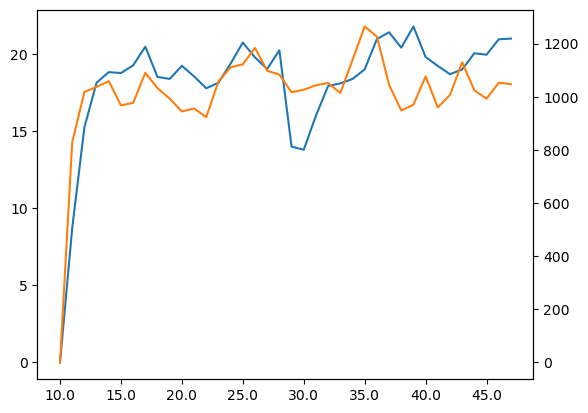

In [201]:
p = 0
fig,axs=plt.subplots(2,1)
ax=axs[0]
mean_dist_with_next = np.diag(mean_euc_d_mean,1)
ax.plot(mean_euc_d_mean[p,p+npos])
ax.plot(mean_euc_d_mean[p,p+1])
ax2 = ax.twinx()
ax2.plot(sigma_euc_d_mean[p],color='C1')
ax.set_xticklabels(pos_l)

(700.0, 1200.0)

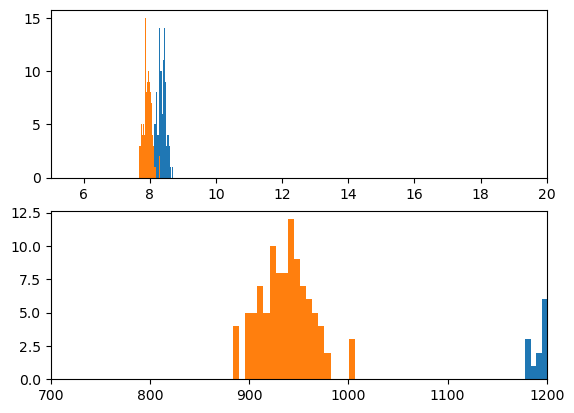

In [195]:
p=7
fig,axs=plt.subplots(2,1)
ax=axs[0]
ax.hist(mean_euc_d[:,p,p+npos],bins=20)
ax.hist(mean_euc_d[:,p,p+1],bins=20)
ax.set_xlim([5,20])
ax=axs[1]
ax.hist(sigma_euc_d[:,p,p+npos],bins=20)
ax.hist(sigma_euc_d[:,p,p+1],bins=20)
ax.set_xlim([700,1200])

In [67]:
sigma_hat_l.shape

(100, 38, 422, 422)

In [45]:
posterior

In [42]:
sigma_hat.shape

(38, 422, 422)

/mnt/home/szheng/projects/wishart-process/visualizations.py:68: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


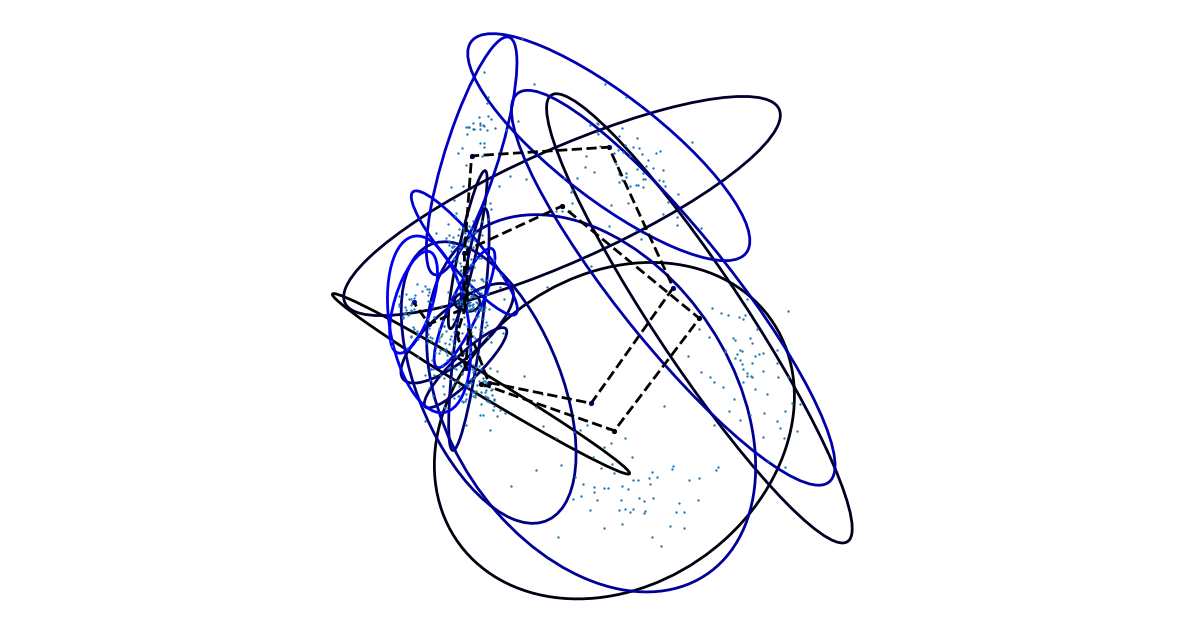

In [96]:
from visualizations import visualize_pc
visualize_pc(mu_hat[:,None],sigma_hat,pc=y.reshape(-1,y.shape[-1]))

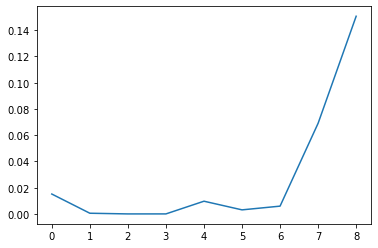

In [22]:
plt.plot(y.mean(axis=0)[:,0])

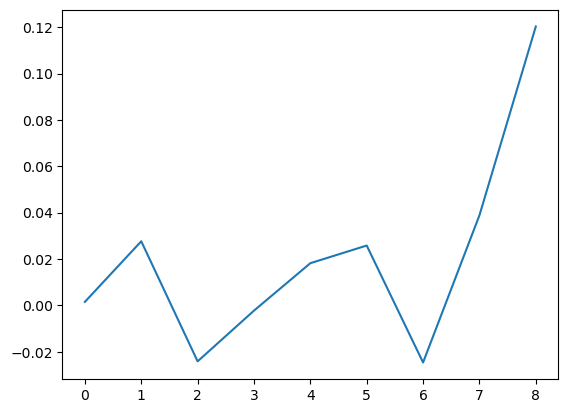

In [26]:
plt.plot(mu_hat[:,0])

In [13]:
# Evaluate the function derivative of the posterior mode 
with numpyro.handlers.seed(rng_seed=seed):
    mu_prime, sigma_prime = posterior.derivative(x)

KeyboardInterrupt: 

In [ ]:
# Posterior distribution
posterior = models.NormalGaussianWishartPosterior(joint,varfam,x)

# Sample from the posterior
with numpyro.handlers.seed(rng_seed=seed):
    mu_hat, sigma_hat, F_hat = posterior.sample(x)

# Evaluate posterior mode
with numpyro.handlers.seed(rng_seed=seed):
    mu_hat, sigma_hat, F_hat = posterior.mode(x)

# Evaluate the function derivative of the posterior mode 
with numpyro.handlers.seed(rng_seed=seed):
    mu_prime, sigma_prime = posterior.derivative(x)

In [80]:
# # RBF kernel
sigma = 0.1
kernel_rbf = lambda x, y: jnp.exp(-jnp.linalg.norm(x-y)**2/(2*sigma**2))

N = 10


# Sample from the generative model and create synthetic dataset
seed=0
n_condition = 5
n_trials = 10
x = jnp.arange(n_condition)
with numpyro.handlers.seed(rng_seed=seed):
    mu = gp.sample(x)
    sigma = wp.sample(x)
    y = jnp.stack([
        likelihood.sample(mu,sigma,ind=jnp.arange(len(mu))) for i in range(n_trials) 
    ]) # K is the number of trials

In [82]:
gp = models.GaussianProcess(kernel=kernel_rbf,num_dims=N) # N is the number of neurons
wp = models.WishartLRDProcess(kernel=kernel_rbf,nu=2,V=jnp.eye(N))
likelihood = models.NormalConditionalLikelihood(D)
# Sample from the generative model and create synthetic dataset
seed=0
n_condition = 5
n_trials = 10
x = jnp.arange(n_condition)
with numpyro.handlers.seed(rng_seed=seed):
    mu = gp.sample(x)
    sigma = wp.sample(x)
    y = jnp.stack([
        likelihood.sample(mu,sigma,ind=jnp.arange(len(mu))) for i in range(n_trials) 
    ]) # K is the number of trials

2023-11-02 16:38:46.924744: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
/mnt/home/szheng/projects/wishart-process/inference.py:29: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  svi_result = svi.run(key, n_iter, x, y, stable_update=True)
  0%|          | 0/20000 [00:00<?, ?it/s]/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/jax/_src/linear_util.py:165: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))
  0%|          | 37/20000 [00:43<6:28:00,  1.17s/it]

KeyboardInterrupt



In [53]:
print(x.shape)
print(y.transpose(1,0,2).shape)

(5,)
(5, 10, 10)


In [83]:
# Given
# -----
# x : ndarray, (num_conditions x num_variables), stimulus conditions.
# y : ndarray, (num_trials x num_conditions x num_neurons), neural firing rates across C conditions repeated for K trials.

# Infer a posterior over neural means and covariances per condition.

# Joint distribution
joint = models.JointGaussianWishartProcess(gp,wp,likelihood) 

# Mean field variational family
varfam = inference.VariationalNormal(joint.model)

# Running inference
varfam.infer(
    optim=optim.Adam(1e-1),
    x=x,y=y,
    n_iter=20000,
    key=jax.random.PRNGKey(seed)
)
joint.update_params(varfam.posterior)

/mnt/home/szheng/projects/wishart-process/inference.py:29: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  svi_result = svi.run(key, n_iter, x, y, stable_update=True)
  0%|          | 0/20000 [00:00<?, ?it/s]/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/jax/_src/linear_util.py:165: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))
100%|██████████| 20000/20000 [00:06<00:00, 3014.30it/s, init loss: 30938.6230, avg. loss [19001-20000]: 582.7653]
